In [6]:
import pandas as pd
import numpy as numpy 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score, classification_report
import os 
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from Preprocessing_pipeline.features import features
from database.db_config import Connection

db= Connection()

connection= db.connect()

ff= features()


data= db.fetch(ff)
print(data)

df= pd.DataFrame(data, columns=[
    'stock_symbol',          # Stock ticker symbol
    'timestamp',             # Date/time of the stock data
    'close', 
    'high', 
    'low',             # Closing price of the stock
    'volume',                # Trading volume of the stock
    'ma_5',                  # 5-day moving average
    'ma_10',                 # 10-day moving average
    'ma_50',                 # 50-day moving average
    'daily_return',          # Daily return percentage
    'intraday_volatility',   # Intraday volatility measure
    'prev_day_close',        # Previous day's closing price
    'prev_day_return',       # Previous day's return percentage
    'price_diff', 
    'target'           # Difference between current close and previous close
                    # Binary target (1 if daily_return > 0, else 0)
]
)

df.head(10)



✅ Connected to the database
[('IBM', datetime.datetime(1999, 11, 1, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=18000))), 96.75, 98.81, 96.37, 9551800, 96.75, 96.75, 96.75, None, None, 96.75, None, 0.0, 0), ('IBM', datetime.datetime(1999, 11, 2, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=18000))), 94.81, 96.81, 93.69, 11105400, 95.78, 95.78, 95.78, -0.020051679586563283, None, 94.81, -0.020051679586563283, 0.0, 0), ('IBM', datetime.datetime(1999, 11, 3, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=18000))), 94.37, 95.94, 93.5, 10369100, 95.31, 95.31, 95.31, -0.004640860668705809, None, 94.37, -0.004640860668705809, 0.0, 0), ('IBM', datetime.datetime(1999, 11, 4, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=18000))), 91.56, 94.44, 90.0, 16697600, 94.3725, 94.3725, 94.3725, -0.029776411995337523, None, 91.56, -0.029776411995337523, 0.0, 0), ('IBM', datetime.datetime(1999, 11, 5, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(secon

,stock_symbol,timestamp,close,high,low,volume,ma_5,ma_10,ma_50,daily_return,intraday_volatility,prev_day_close,prev_day_return,price_diff,target
0,IBM,1999-11-01 00:00:00+05:00,96.75,98.81,96.37,9551800,96.7500,96.750000,96.750000,NaN,NaN,96.75,NaN,0.0,0
1,IBM,1999-11-02 00:00:00+05:00,94.81,96.81,93.69,11105400,95.7800,95.780000,95.780000,-0.020052,NaN,94.81,-0.020052,0.0,0
2,IBM,1999-11-03 00:00:00+05:00,94.37,95.94,93.50,10369100,95.3100,95.310000,95.310000,-0.004641,NaN,94.37,-0.004641,0.0,0
3,IBM,1999-11-04 00:00:00+05:00,91.56,94.44,90.00,16697600,94.3725,94.372500,94.372500,-0.029776,NaN,91.56,-0.029776,0.0,0
4,IBM,1999-11-05 00:00:00+05:00,90.25,92.94,90.19,13737600,93.5480,93.548000,93.548000,-0.014308,NaN,90.25,-0.014308,0.0,0
5,IBM,1999-11-08 00:00:00+05:00,93.94,93.94,90.50,8522300,92.9860,93.613333,93.613333,0.040886,NaN,93.94,0.040886,0.0,1
6,IBM,1999-11-09 00:00:00+05:00,93.62,95.50,92.12,9551200,92.7480,93.614286,93.614286,-0.003406,NaN,93.62,-0.003406,0.0,0
7,IBM,1999-11-10 00:00:00+05:00,97.00,97.06,94.12,8680300,93.2740,94.037500,94.037500,0.036103,NaN,97.00,0.036103,0.0,1
8,IBM,1999-11-11 00:00:00+05:00,95.00,97.50,94.87,7147500,93.9620,94.144444,94.144444,-0.020619,NaN,95.00,-0.020619,0.0,0
9,IBM,1999-11-12 00:00:00+05:00,95.87,96.25,93.00,9668400,95.0860,94.317000,94.317000,0.009158,NaN,95.87,0.009158,0.0,1


In [7]:
df['intraday_volatility'].fillna(df['intraday_volatility'].mean(), inplace=True)
df['daily_return'].fillna(0, inplace=True)
df['prev_day_return'].fillna(0, inplace=True)
df.dropna(inplace=True)

df["price_momentum"] = df["price_diff"] / df["prev_day_close"]  # Price momentum ratio
df["volatility_ratio"] = df["intraday_volatility"] / df["ma_10"]  # Normalized volatility
df["volume_change"] = df["volume"].pct_change()  # Percentage change in volume




import numpy as np
import pandas as pd

# Calculate Exponential Moving Averages (EMA)
df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()
df['ema_20'] = df['close'].ewm(span=20, adjust=False).mean()

# Calculate Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi'] = calculate_rsi(df['close'])

# Rate of Change (ROC)
df['roc'] = df['close'].pct_change(periods=10) * 100  # Percentage change over 10 days

# Average True Range (ATR)
df['high_low'] = df['high'] - df['low']
df['high_close'] = (df['high'] - df['close'].shift()).abs()
df['low_close'] = (df['low'] - df['close'].shift()).abs()
df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
df['atr'] = df['tr'].rolling(window=14).mean()

# Bollinger Bands
df['bollinger_upper'] = df['ma_10'] + (2 * df['atr'])
df['bollinger_lower'] = df['ma_10'] - (2 * df['atr'])

# Price-Volume Trend (PVT)
df['pvt'] = (df['volume'] * df['daily_return']).cumsum()

# On-Balance Volume (OBV)
df['obv'] = (np.sign(df['daily_return']).shift(1) * df['volume']).cumsum()

# Chaikin Money Flow (CMF)
df['cmf'] = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low']) * df['volume']
df['cmf'] = df['cmf'].rolling(window=20).mean()

df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['ema_26'] = df['close'].ewm(span=26, adjust=False).mean()

# MACD (Moving Average Convergence Divergence)
df['macd'] = df['ema_12'] - df['ema_26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Parabolic SAR
df['sar'] = df['close'].shift(1) + 0.02 * (df['close'] - df['close'].shift(1))  # Simplified version

# Lag Features (previous day's price, volume, and return)
df['prev_day_close'] = df['close'].shift(1)
df['prev_day_volume'] = df['volume'].shift(1)
df['prev_day_return'] = df['daily_return'].shift(1)


df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Day of Week & Month of Year
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month_of_year'] = df['timestamp'].dt.month

# Sentiment features (placeholder, to be replaced with actual sentiment data)
# df['news_sentiment'] = get_sentiment_data(df['stock_symbol'])
# df['earnings_sentiment'] = get_earnings_sentiment_data(df['stock_symbol'])

# Statistical Features
df['skewness'] = df['daily_return'].rolling(window=14).skew()
df['kurtosis'] = df['daily_return'].rolling(window=14).kurt()

# Autocorrelation (lag 1 and 5)
df['autocorrelation_1'] = df['daily_return'].shift(1).corr(df['daily_return'])
df['autocorrelation_5'] = df['daily_return'].shift(5).corr(df['daily_return'])

# Drop rows with NaN values after creating lag features
df.dropna(inplace=True)

# Reorder columns to make it more readable
df = df[['stock_symbol', 'timestamp', 'close', 'volume', 'ma_5', 'ma_10', 'ma_50', 'daily_return', 
         'intraday_volatility', 'prev_day_close', 'prev_day_return', 'price_diff', 'price_momentum', 
         'volatility_ratio', 'volume_change', 'ema_10', 'ema_20', 'rsi', 'roc', 'atr', 'bollinger_upper', 
         'bollinger_lower', 'pvt', 'obv', 'cmf', 'macd', 'macd_signal', 'sar', 'prev_day_volume', 
         'day_of_week', 'month_of_year', 'skewness', 'kurtosis', 'autocorrelation_1', 'autocorrelation_5', 
         'target']]

# Checking the head of the DataFrame to verify
df.head(20)



C:\Users\Home\AppData\Local\Temp\ipykernel_6272\189946277.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['intraday_volatility'].fillna(df['intraday_volatility'].mean(), inplace=True)
C:\Users\Home\AppData\Local\Temp\ipykernel_6272\189946277.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

,stock_symbol,timestamp,close,volume,ma_5,ma_10,ma_50,daily_return,intraday_volatility,prev_day_close,...,macd_signal,sar,prev_day_volume,day_of_week,month_of_year,skewness,kurtosis,autocorrelation_1,autocorrelation_5,target
19,IBM,1999-11-29 00:00:00+05:00,104.19,5677700,105.524,101.199,97.758000,-0.007714,0.420688,105.00,...,1.327194,104.9838,3108400.0,0.0,11.0,0.825122,-0.617060,-0.038431,-0.012747,0
20,IBM,1999-11-30 00:00:00+05:00,103.06,5758700,104.562,102.099,98.010476,-0.010846,0.420688,104.19,...,1.536700,104.1674,5677700.0,1.0,11.0,0.842635,-0.652867,-0.038431,-0.012747,0
21,IBM,1999-12-01 00:00:00+05:00,103.42,5336400,104.034,102.979,98.256364,0.003493,0.420688,103.06,...,1.696423,103.0672,5758700.0,2.0,12.0,1.169269,0.356245,-0.038431,-0.012747,1
22,IBM,1999-12-02 00:00:00+05:00,105.27,6216900,104.188,104.131,98.561304,0.017888,0.420688,103.42,...,1.842220,103.4570,5336400.0,3.0,12.0,1.021924,0.131841,-0.038431,-0.012747,1
23,IBM,1999-12-03 00:00:00+05:00,111.87,14680300,105.562,105.518,99.115833,0.062696,0.420688,105.27,...,2.072745,105.4020,6216900.0,4.0,12.0,0.808205,-0.793224,-0.038431,-0.012747,1
24,IBM,1999-12-06 00:00:00+05:00,116.00,9928300,107.924,106.724,99.791200,0.036918,0.420688,111.87,...,2.405460,111.9526,14680300.0,0.0,12.0,0.547058,-1.192200,-0.038431,-0.012747,1
25,IBM,1999-12-07 00:00:00+05:00,116.62,11326100,110.636,107.599,100.438462,0.005345,0.420688,116.00,...,2.789193,116.0124,9928300.0,1.0,12.0,0.550813,-1.193260,-0.038431,-0.012747,1
26,IBM,1999-12-08 00:00:00+05:00,118.28,8139800,113.608,108.821,101.099259,0.014234,0.420688,116.62,...,3.204913,116.6532,11326100.0,2.0,12.0,0.457614,-1.099199,-0.038431,-0.012747,1
27,IBM,1999-12-09 00:00:00+05:00,113.37,16643000,115.228,109.708,101.537500,-0.041512,0.420688,118.28,...,3.533251,118.1818,8139800.0,3.0,12.0,0.333665,-0.349708,-0.038431,-0.012747,0
28,IBM,1999-12-10 00:00:00+05:00,109.00,12588800,114.654,110.108,101.794828,-0.038546,0.420688,113.37,...,3.711831,113.2826,16643000.0,4.0,12.0,0.348647,-0.003705,-0.038431,-0.012747,0


In [8]:
from sklearn.preprocessing import StandardScaler

# Select numerical features for scaling
numerical_features = ['close', 'volume', 'ma_5', 'ma_10', 'ma_50', 'daily_return', 'intraday_volatility', 
                      'price_diff', 'price_momentum', 'volatility_ratio', 'volume_change', 'ema_10', 'ema_20', 
                      'rsi', 'roc', 'atr', 'bollinger_upper', 'bollinger_lower', 'pvt', 'obv', 'cmf', 'macd', 
                      'macd_signal', 'sar', 'prev_day_volume', 'skewness', 'kurtosis', 'autocorrelation_1', 
                      'autocorrelation_5']

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


In [9]:
from sklearn.model_selection import train_test_split

# Sort data by timestamp
df = df.sort_values(by='timestamp')

# Split the data into features (X) and target (y)
X = df[numerical_features]
y = df['target']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Performance:\n", classification_report(y_test, y_pred_lr))

import pickle

with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(lr_model,file)

Logistic Regression Performance:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       553
           1       0.99      0.99      0.99       639

    accuracy                           0.99      1192
   macro avg       0.99      0.99      0.99      1192
weighted avg       0.99      0.99      0.99      1192



In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Initialize and train XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Performance:\n", classification_report(y_test, y_pred_xgb))


XGBoost Performance:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       553
           1       1.00      1.00      1.00       639

    accuracy                           1.00      1192
   macro avg       1.00      1.00      1.00      1192
weighted avg       1.00      1.00      1.00      1192



C:\Users\Home\AppData\Local\Temp\ipykernel_6196\1788444811.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"], palette="viridis")


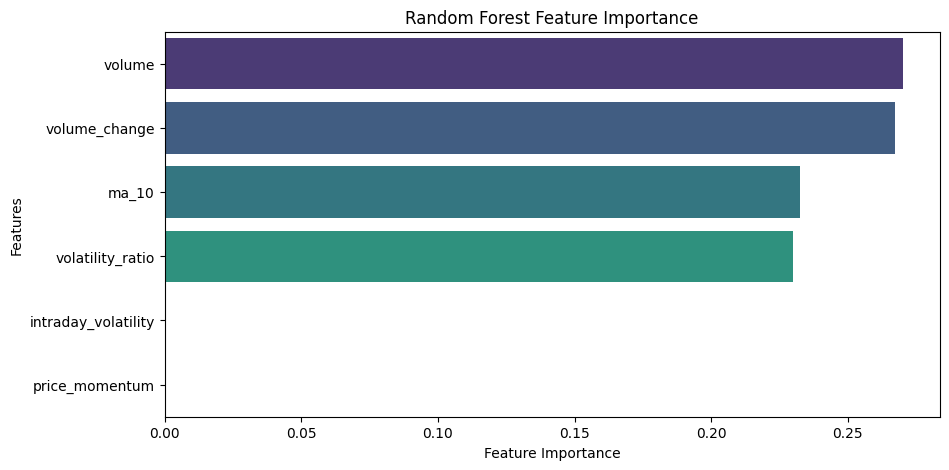

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming rf_model is your trained RandomForestClassifier
importances = model.feature_importances_
feature_names = selected_features

# Create a DataFrame
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"], palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.show()


In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Standardizing the selected features


selected_features = ["ma_10", "volume","volatility_ratio", "volume_change"]
X = df[selected_features]
y = df["target"]

print('this is y 1', (y==1).sum())
print('this is x 0', (y==0).sum())


X['volume_change']=X['volume_change'].fillna(0)
print('these ar nans in X', X.isna().sum())
print('these are nans in y', y.isna().sum())



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X contains selected features



# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

from sklearn.impute import SimpleImputer

# Impute with mean
# imputer = SimpleImputer(strategy="mean")
# X_train = imputer.fit_transform(X_train)
# X_test = imputer.transform(X_test)




# Train Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predictions & Accuracy
y_pred = log_reg.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {log_reg_accuracy:.2f}")


this is y 1 3247
this is x 0 3105
these ar nans in X ma_10               0
volume              0
volatility_ratio    0
volume_change       0
dtype: int64
these are nans in y 0
Logistic Regression Accuracy: 0.52


C:\Users\Home\AppData\Local\Temp\ipykernel_6196\2467731984.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['volume_change']=X['volume_change'].fillna(0)


Index(['stock_symbol', 'timestamp', 'close', 'volume', 'ma_5', 'ma_10',
       'ma_50', 'daily_return', 'intraday_volatility', 'prev_day_close',
       'prev_day_return', 'price_diff', 'target', 'price_momentum',
       'volatility_ratio', 'volume_change'],
      dtype='object')


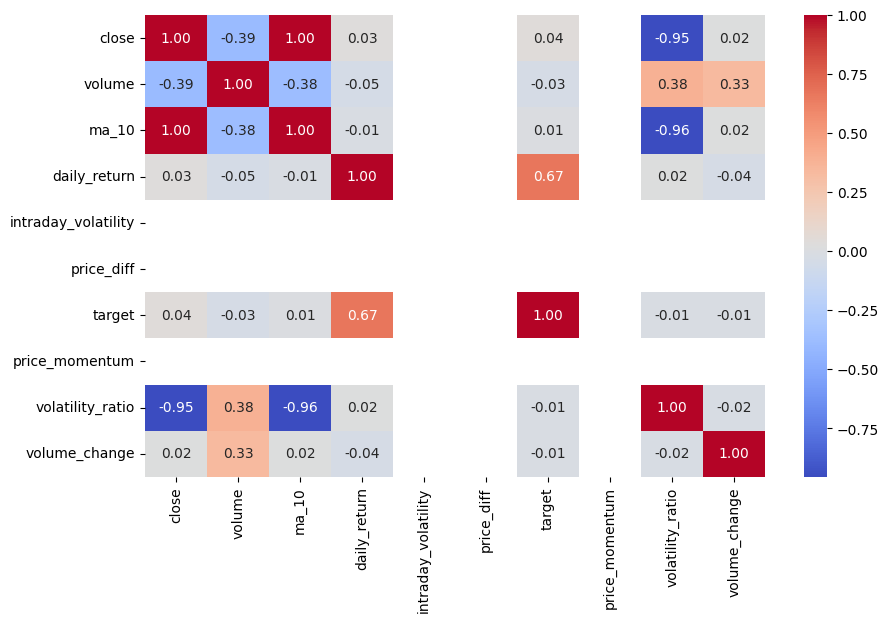

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

print(df.columns)

ff= [ 'close', 'volume',  'ma_10',
        'daily_return', 'intraday_volatility', 
        'price_diff', 'target', 'price_momentum',
       'volatility_ratio', 'volume_change']

df=df[ff]


plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()